**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4029 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 8**
Regresión Lineal

---

*   NOMBRES: 
    - Alexandro Mayoral Terán
    - Carolina Valle Gutiérrez
    - Arthur Jafed Zizumbo Velasco
    
*   MATRÍCULAS: 
    - A01795899
    - A01734834
    - A01796363

In [1]:
# Se comento debido a que se utilizo VSCode
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Se comento debido a que se utilizo VSCode
# import os
# DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC4029 - Ciencia y analítica de datos/Semana 8/Actividad8_RLineal"
# os.chdir(DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.ticker as mtick


In [4]:
insurance_df = pd.read_csv('insurance.csv')
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# **Parte 1**. EDA

Efectúa una exploración inicial de los datos a través de:

1a) Estadísticas descriptivas para todas las variables del dataframe.

Recordemos que es cada variable:

* **age**: edad del asegurado
* **sex**: sexo
* **bmi**: índice de masa corporal
* **children**: número de hijos
* **smoker**: indicador de si fuma
* **region**: región donde vive el asegurado
* **charges**: prima del seguro

In [5]:
n_rows = insurance_df.shape[0]
ncols = insurance_df.shape[1]
print('Dimensiones del data frame:')
print(f'Filas {n_rows}, Columnas {ncols}')

Dimensiones del data frame:
Filas 1338, Columnas 7


In [6]:
def descriptive_statistics(df, quantitative_cols=None, qualitative_cols=None):
    # Variables cuantitativas
    if quantitative_cols is None:
        quantitative_cols = df.select_dtypes(include='number').columns.tolist()

    # Variables cualitativas
    if qualitative_cols is None:
        qualitative_cols = df.select_dtypes(include='object').columns.tolist()

    # Aplicamos las funciones a las columnas cuantitativas usando .agg()
    quantitative_stats_df = df[quantitative_cols].agg(
        ['count', 'mean', 'std', 'min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), 'max']
    ).transpose()
    quantitative_stats_df.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    # Calculamos métricas adicionales (missing_count y missing_proportion) para las columnas cuantitativas
    quantitative_stats_df['missing_count'] = df[quantitative_cols].isna().sum()
    quantitative_stats_df['missing_proportion'] = df[quantitative_cols].isna().mean()

    # # Aplicamos funciones para las variables cualitativas sin usar .agg() directamente debido a incompatibilidades
    qualitative_stats_list = []
    for col in qualitative_cols:
        col_series = df[col]
        col_custom_stats = {
            'variable': col,
            'count': col_series.count(),
            'unique_count': col_series.nunique(),
            'mode': col_series.mode().iloc[0] if not col_series.mode().empty else None,
            'mode_frequency': col_series.value_counts().iloc[0] if not col_series.value_counts().empty else 0,
            'mode_proportion': col_series.value_counts(normalize=True).iloc[0] if not col_series.value_counts().empty else 0,
            'missing_count': col_series.isna().sum(),
            'missing_proportion': col_series.isna().mean()
        }
        qualitative_stats_list.append(col_custom_stats)
    qualitative_stats_df = pd.DataFrame(qualitative_stats_list).set_index('variable')

    return quantitative_stats_df, qualitative_stats_df

In [7]:
# Obtenemos las estadísticas con la funcion que definimos
quantitative_df, qualitative_df = descriptive_statistics(insurance_df)

In [8]:
display('Variables cuantitativas:')
display(quantitative_df)
display('Variables cualitativas:')
display(qualitative_df)

'Variables cuantitativas:'

,count,mean,std,min,25%,50%,75%,max,missing_count,missing_proportion
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000,0,0.0
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000,0,0.0
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000,0,0.0
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801,0,0.0


'Variables cualitativas:'

,count,unique_count,mode,mode_frequency,mode_proportion,missing_count,missing_proportion
variable,,,,,,,
sex,1338,2,male,676,0.505232,0,0.0
smoker,1338,2,no,1064,0.795217,0,0.0
region,1338,4,southeast,364,0.272048,0,0.0


Si bien el tipo de dato para `children` podría considerarse categoríca al ya ser un número consideramos mantenerla para los análisis como numérica, recordar que es el número de hijos.

Adicionalmente se observa que en promedio la edad es de 39 años y un índice de masa corporal de 30, en cuanto a la prima del seguro vemos que parece que tenemos outliers al ver que la mediana y el promedio varian, la mediana es de 9,382.

Respecto a las variales categorícas el género están en proporciones similares hombre y mujer, se tiene mayor cantidad de no fumadores (~80%), la region también se distribuyen de manera similar, en cuanto al número de hijos vemos que alrededor del 50% no tiene hijos. 

1b) Búsqueda de valores faltantes.

In [9]:
display('Valores faltantes en variables cuantitativas:')
display(quantitative_df[['missing_count', 'missing_proportion']])
display('Valores faltantes en variables cualitativas:')
display(qualitative_df[['missing_count','missing_proportion']])

'Valores faltantes en variables cuantitativas:'

,missing_count,missing_proportion
age,0,0.0
bmi,0,0.0
children,0,0.0
charges,0,0.0


'Valores faltantes en variables cualitativas:'

,missing_count,missing_proportion
variable,,
sex,0,0.0
smoker,0,0.0
region,0,0.0


No tenemos valores fantantes en ninguna de las variables.

1c) Histrogramas y boxplots para las variables cuantitativas y diagramas de barras con la frecuencia para las variables categóricas.

In [10]:
def color_aleatorio_hex():
  """Genera un color hexadecimal aleatorio.
  Returns:
    str: Una cadena de texto que representa un color hexadecimal en el formato '#RRGGBB'.
  """
  # Generar un entero aleatorio entre 0 y 0xFFFFFF (16777215 en decimal)
  random_number = random.randint(0, 0xFFFFFF)
  # Formatear el número como una cadena hexadecimal con el prefijo '#'
  hex_color_code = '#{:06x}'.format(random_number)
  return hex_color_code


In [11]:
def drawCategoriesBar(df, col, palette, size):
    plt.figure(figsize=size)
    ax = sns.countplot(x=df[col], hue=col, data=df, palette=palette, legend=False)
    plt.xlabel(None)
    plt.ylabel('Frecuencia')
    plt.title(f'Frecuencia de categorías en: {col}', fontweight='bold', fontname='serif', fontsize= 16)
    plt.grid(True, linestyle='--', alpha=0.6)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height/2, height,
                ha="center", 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'),
                fontweight='bold', fontname='serif', fontsize= 16)
    plt.show()

In [12]:
def tipo_asimetria(asimetria):
    if asimetria > 0:
        tipo_asimetria = 'Asimétrica positiva (derecha)'
    elif asimetria < 0:
        tipo_asimetria = 'Asimétrica negativa (izquierda)'
    else:
        tipo_asimetria = 'Simétrica'
    return tipo_asimetria

def tipo_curtosis(curtosis):
    if curtosis > 0:
        tipo_curtosis = 'Leptocúrtica (colas pesadas)'
    elif curtosis < 0:
        tipo_curtosis = 'Platicúrtica (colas ligeras)'
    else:
        tipo_curtosis = 'Mesocúrtica (normal)'
    return tipo_curtosis

In [13]:
def drawHistograms(df, bins, subX, subY):
    fig, axes = plt.subplots(subY,subX, figsize=(20,6))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    axes = axes.ravel() if subX > 1 else [axes]

    for col, ax in zip(df, axes):
        color = color_aleatorio_hex()
        # Estadisticas
        asimetria = df[col].skew()
        curtosis = df[col].kurtosis()
        media = df[col].mean()
        mediana = df[col].median()
        moda = df[col].mode()[0]
        
        sns.histplot(x= df[col], ax=ax, bins=bins, kde=True, color=color )
        ax.set(xlabel=None)
        ax.set_ylabel('Frecuencia', fontname='serif', fontsize= 14)
        ax.set_title(f'Distribución de {col}\nAsimetría: {asimetria:.2f}, Curtosis: {curtosis:.2f}\n{tipo_asimetria(asimetria)} y {tipo_curtosis(curtosis)}', fontname='serif', fontsize= 10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.axvline(media, color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='dashed', linewidth=1.5, label=f'Mediana: {mediana:.2f}')
        ax.axvline(moda, color='purple', linestyle='dashed', linewidth=1.5, label=f'Moda: {moda:.2f}')
        ax.legend()

In [14]:
def drawBoxPlots(df,subX, subY):
    figBP, axesBP = plt.subplots(subX, subY, figsize=(20,8))
    axesBP = axesBP.ravel()
    plt.subplots_adjust(hspace=0.6)

    for col, ax in zip(df, axesBP):
        color = color_aleatorio_hex()
        sns.boxplot(x=df[col], ax=ax, showmeans=True, color=color )
        ax.set(xlabel=None)
        ax.set_title(f'{col}', fontweight='bold', fontname='serif', fontsize= 16)

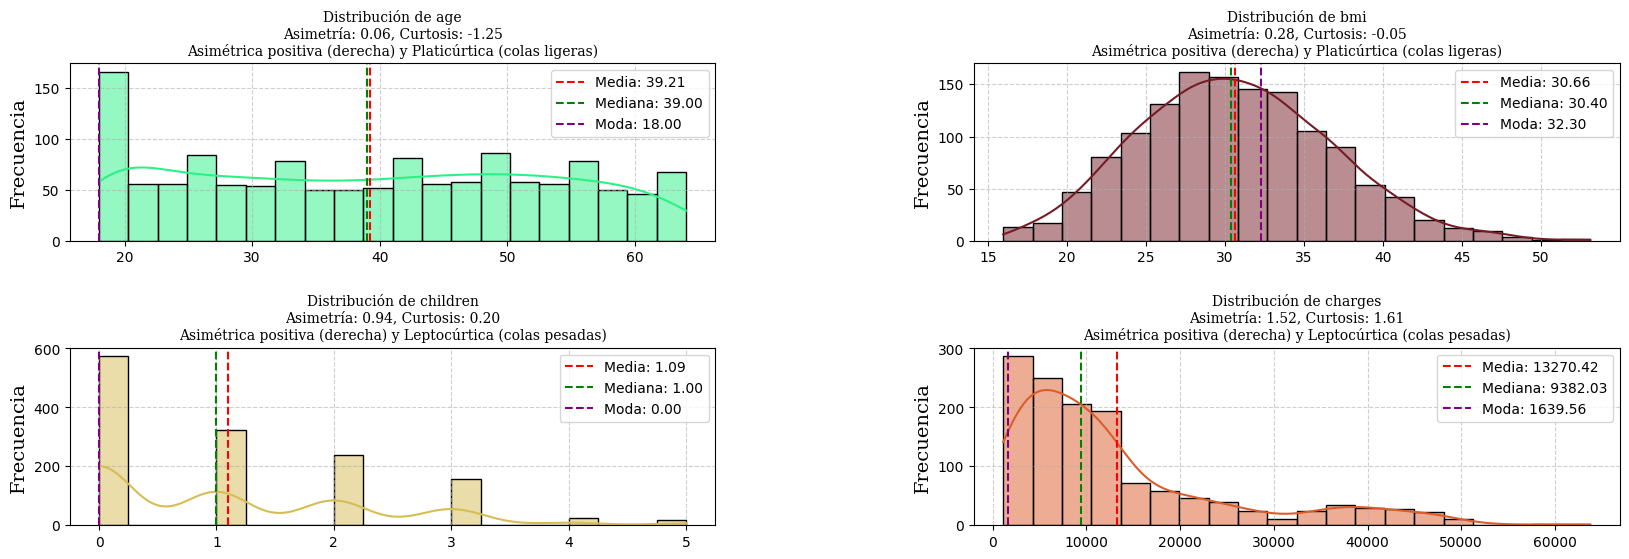

In [15]:
drawHistograms(insurance_df.select_dtypes(include='number'), 20, 2, 2)

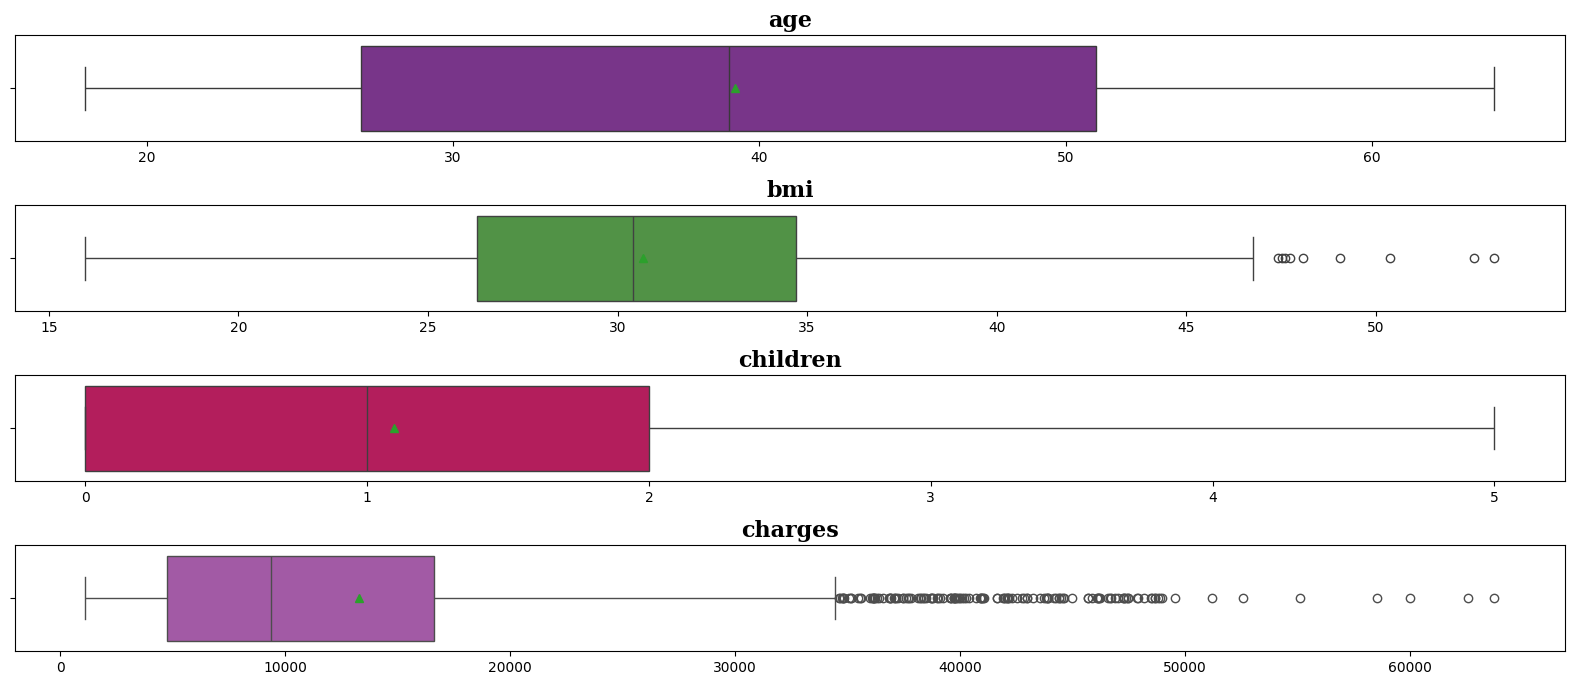

In [16]:
drawBoxPlots(insurance_df.select_dtypes(include='number'), 4, 1)

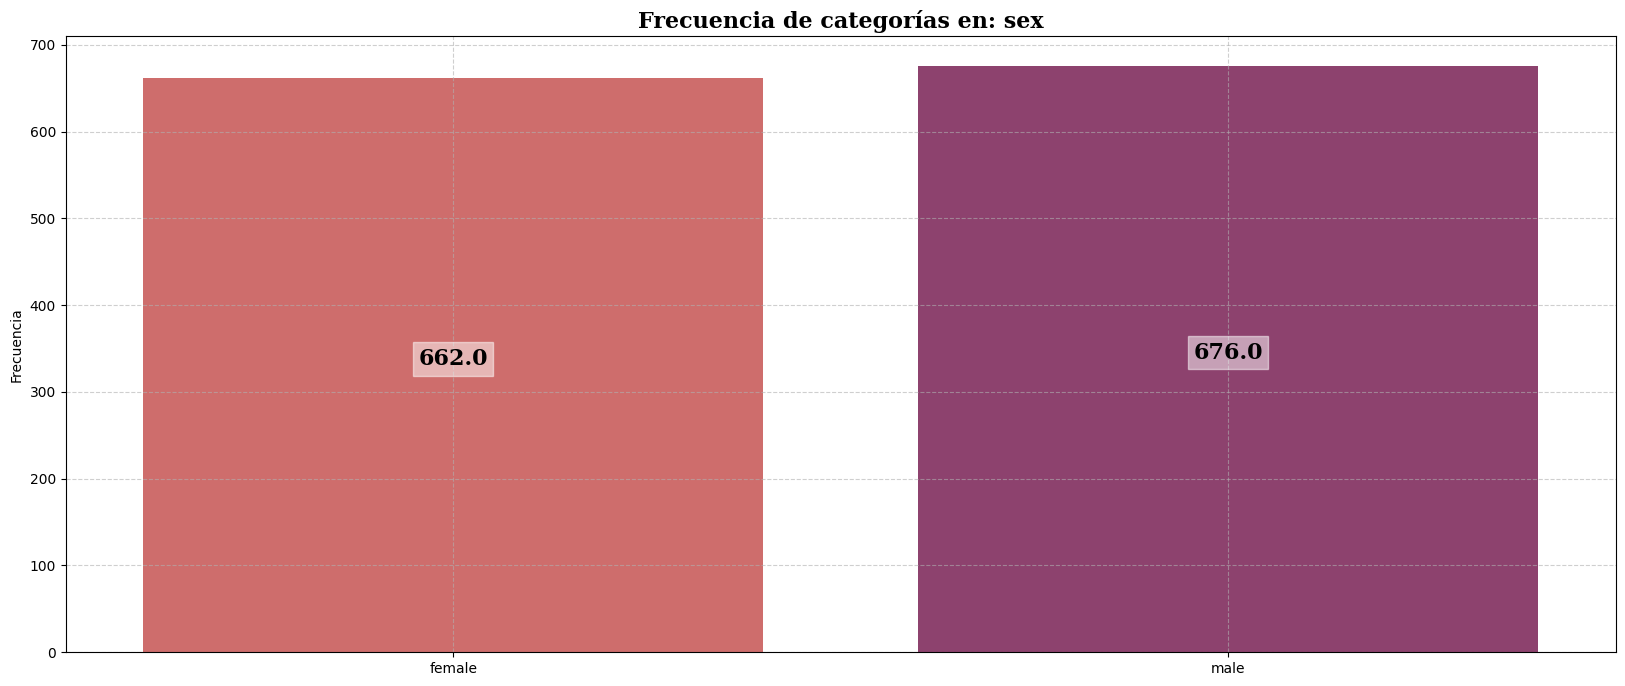

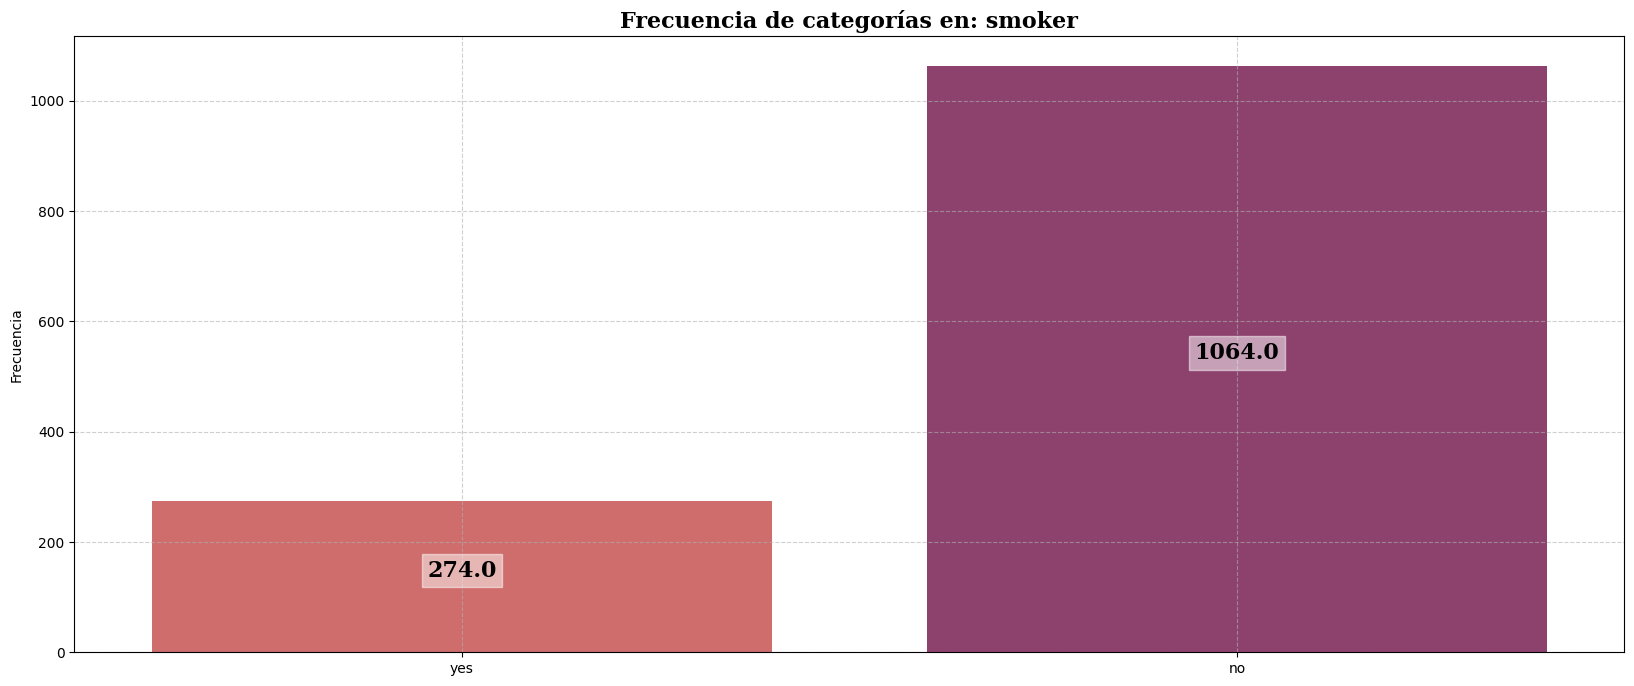

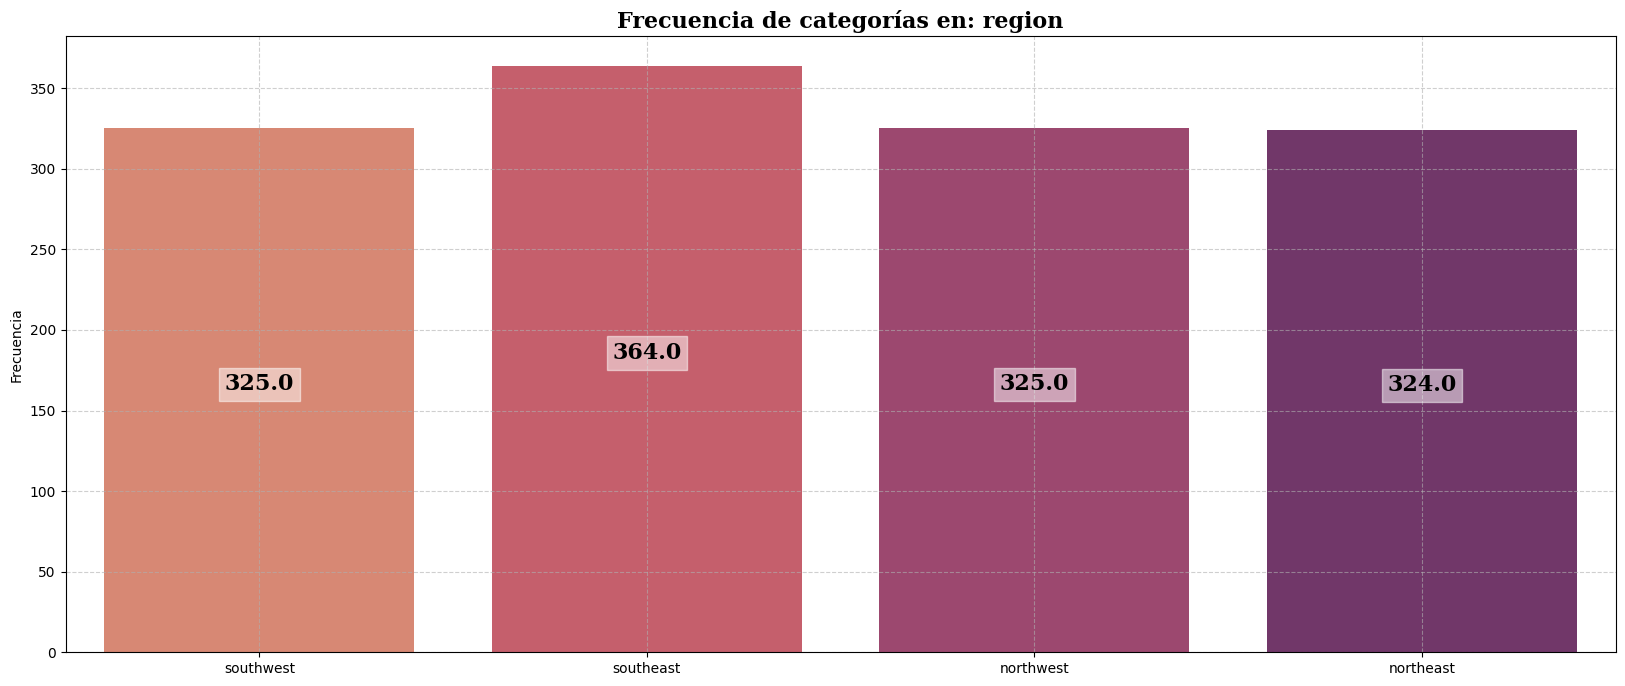

In [17]:
for col in (insurance_df.select_dtypes(exclude='number')).columns:
    drawCategoriesBar(insurance_df.select_dtypes(exclude='number'), col, 'flare', (20,8))


Para responder los siguientes cuestionamientos, genera los gráficos indicados:

2a) ¿Hay diferencias significativas de las primas según el sexo? Compara la distribución de la variable `charges` por medio de un boxplot.

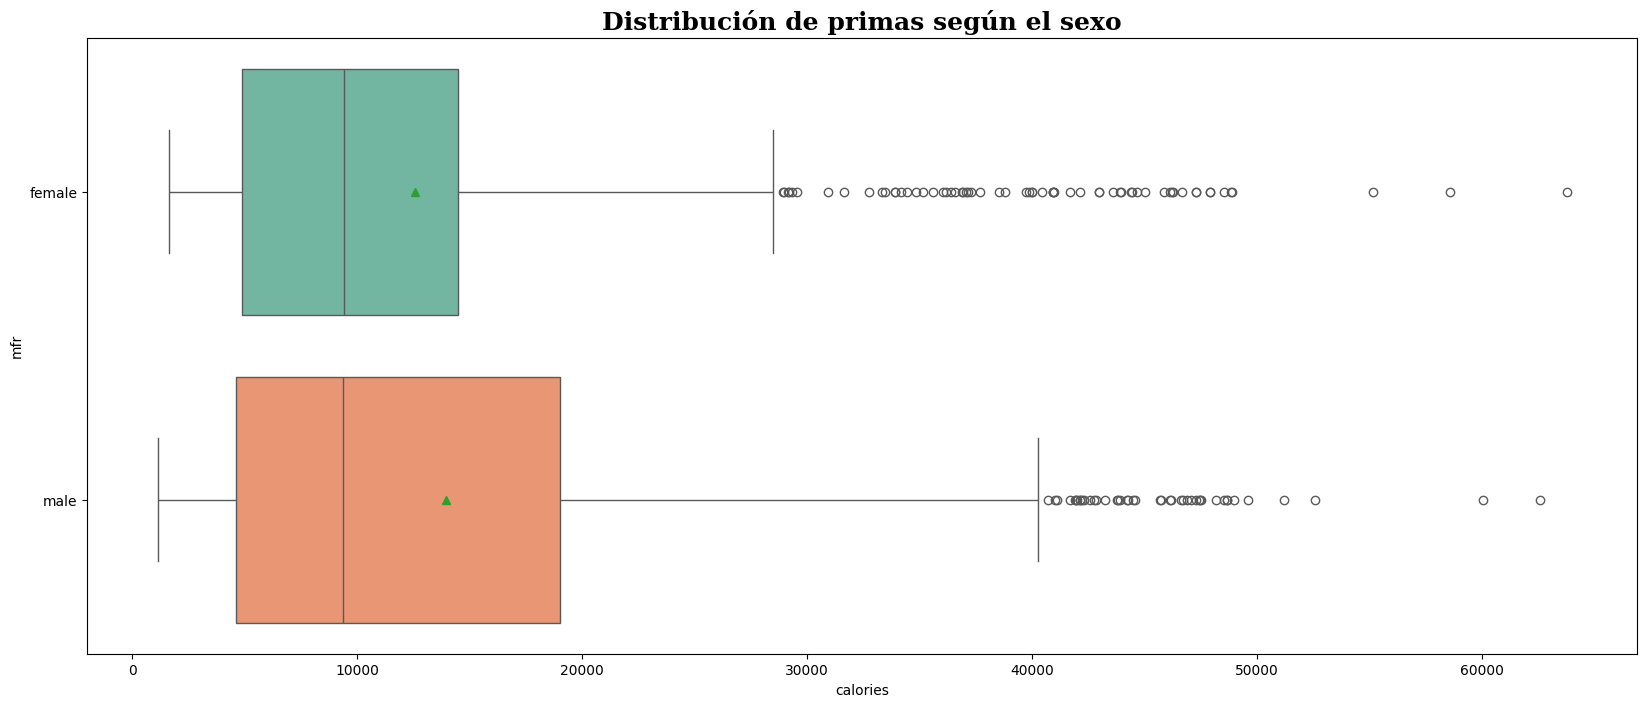

In [18]:
plt.figure(figsize=(20,8))
ax = sns.boxplot(x='charges', y='sex', hue='sex', data=insurance_df, legend=False, showmeans=True, palette=sns.color_palette("Set2", 2) )
plt.xlabel('calories')
plt.ylabel('mfr')
plt.title('Distribución de primas según el sexo', fontweight='bold', fontname='serif', fontsize= 18 )
plt.show()

In [19]:
from scipy import stats

females = insurance_df[insurance_df['sex'] == 'female']['charges']
males = insurance_df[insurance_df['sex'] == 'male']['charges']

# Aplicamos una prueba 't' para muestras independientes
t_stat_sex, p_value_sex = stats.ttest_ind(males, females, equal_var=False)  # equal_var=False asume varianzas desiguales

print(f'Estadístico: {t_stat_sex}')
print(f'p-value: {p_value_sex}')

Estadístico: 2.1008878232359565
p-value: 0.03584101495601664


Dado que el valor del _p-value_ es menor que un nivel de significancia típico de _0.05_, podemos concluir que existe una diferencia significativa en los costos del seguro entre hombres y mujeres. Sin embargo si consideramos una significancia de _0.03_ cambiaría la conclusión, la diferencia no es tan extrema. Por ejemplo con 'smokers' se nota mucho más la diferencia. Si hay diferencias en las primas el rango es mayor para los hombres, y en las mujeres hay más valores atípicos

2b) Crea un diagrama de dispersión de `charges` versus el `bmi` que incorpore la distinción por las categorías `smoker` y `children` (tip: utiliza el parámetro `size`) ¿Hay alguna conclusión importante que se derive del gráfico?

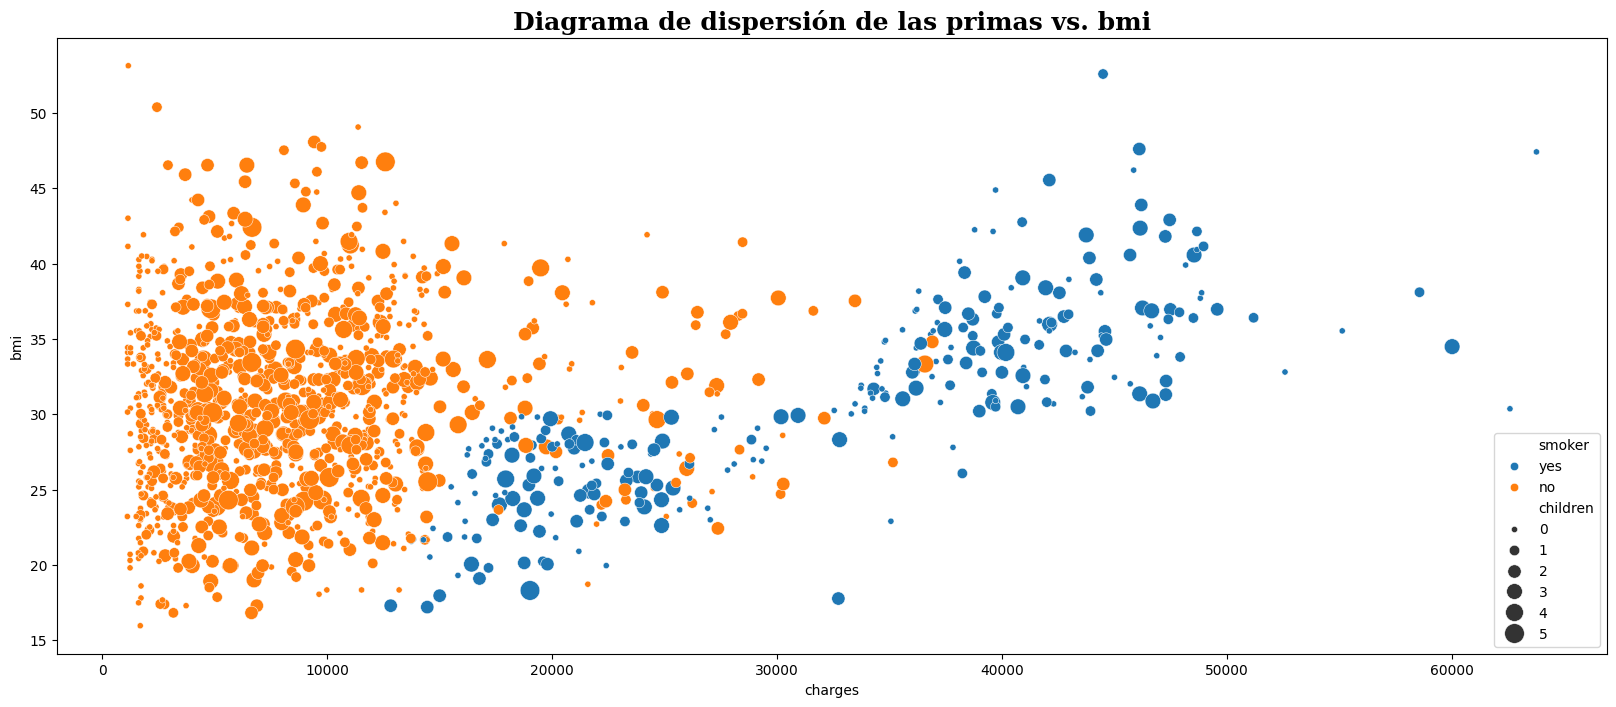

In [20]:
plt.figure(figsize = (20,8) )
sns.scatterplot(x='charges', y='bmi', data=insurance_df, hue='smoker', size='children', sizes=(20, 200))
plt.title('Diagrama de dispersión de las primas vs. bmi', fontweight='bold', fontname='serif', fontsize= 18)
plt.show()


* Relación entre charges y bmi:  A primera vista, no parece haber una correlación lineal fuerte entre los cargos y el bmi. Sin embargo, se puede observar una ligera tendencia a que las primas aumentan a medida que el bmi aumenta, especialmente para los fumadores.

* Influencia de smoker:  Se observa una clara diferencia entre fumadores y no fumadores. Los fumadores (puntos azules) tienden a tener cargos significativamente más altos que los no fumadores (puntos naranjas), independientemente de su bmi. Esto sugiere que fumar es un factor importante que influye en las primas.

* Influencia de children:  La influencia de la cantidad de hijos es menos evidente en el diagrama. Aunque algunos puntos más grandes (que representan más hijos) parecen tener cargos más altos, la relación no es tan clara como con la variable smoker.

2c) Elabora un mapa de calor que muestre la correlación de las variables numéricas.

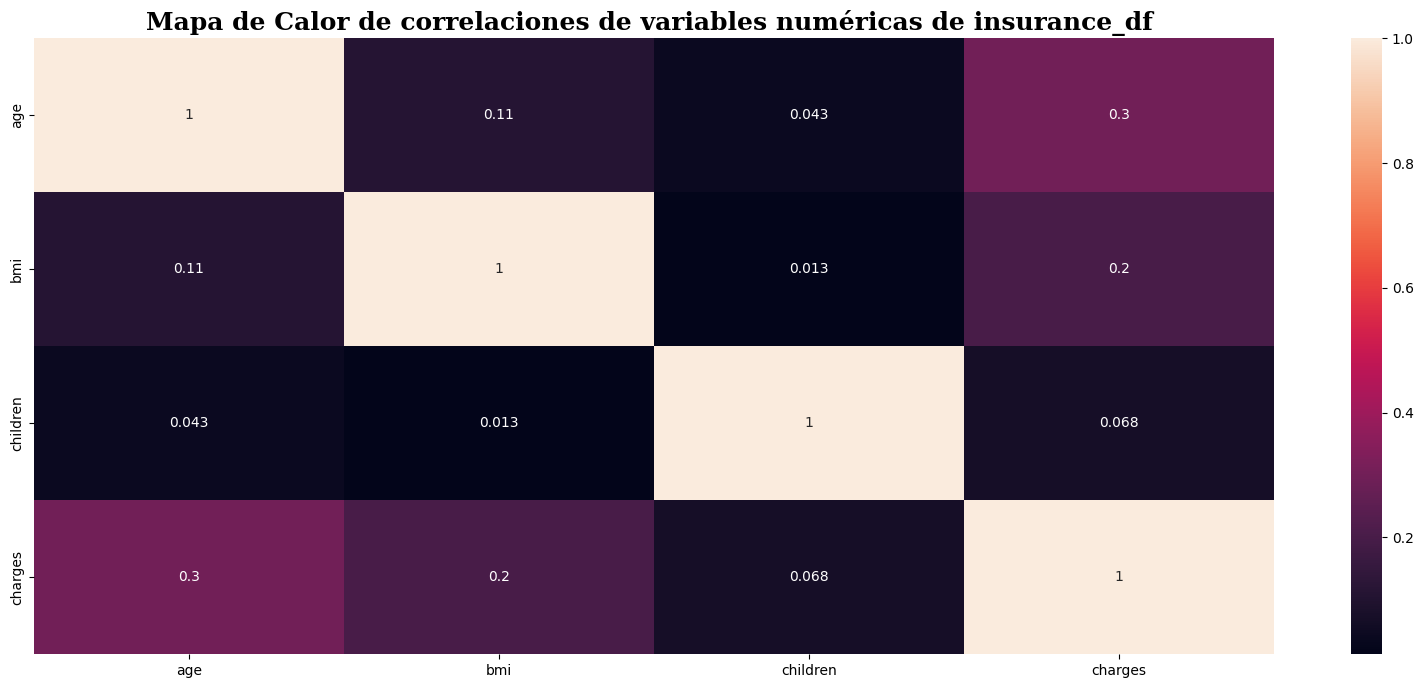

In [21]:
plt.figure(figsize=(20,8))
sns.heatmap(round(insurance_df.corr(numeric_only=True),4), annot = True )
plt.title('Mapa de Calor de correlaciones de variables numéricas de insurance_df ', fontweight='bold', fontname='serif', fontsize= 18 )
plt.show()

Vemos que de las variables que están correlacionadas con `charges` la mayor es `age` con una correlación positiva de 0.3 siguiendo `bmi` con 0.2 y muy poco `children`

Obtén un dataframe con las observaciones que tengan valores atípicos en `charges`.

3a) ¿Cuál es el promedio de `age` y de `bmi` en el dataframe de valores atípicos obtenido?

In [22]:
def calculateOutliersInCol(df, col):
    # Calcula el primer y tercer cuartil (Q1 y Q3)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    # Calcula el rango intercuartil (IQR)
    IQR = Q3 - Q1
    # Calcula los límites inferior y superior
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lowerBound) | (df[col] > upperBound)]
    outliersDf = outliers.copy()
    # Mostrar el número de valores atípicos
    display(f"Número de valores atípicos en '{col}': {len(outliers)}")
    display(f"Porcentaje de los registros de la columna '{col}' de valores atípicos:  { (len(outliers)/df.shape[0]) *100 }%")
    color =color_aleatorio_hex()
    # Vuelve a graficar el la variable para corroborar que ya no tenga valores atípicos
    sns.boxplot(x=df[col], color=color)
    plt.show()
    display(outliersDf)
    return outliersDf

"Número de valores atípicos en 'charges': 139"

"Porcentaje de los registros de la columna 'charges' de valores atípicos:  10.388639760837071%"

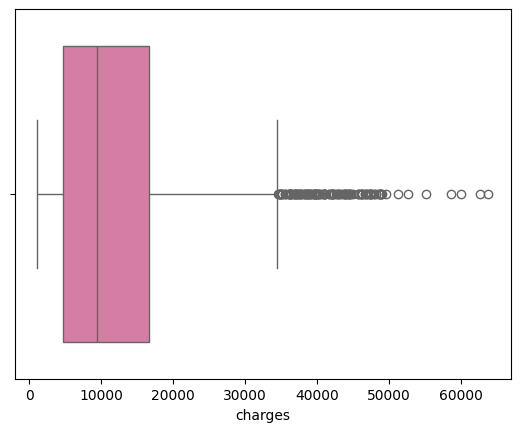

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


In [23]:
chargesOutliers = calculateOutliersInCol(insurance_df, 'charges')

In [24]:
display(f'Promedio de age en outliersCharges: {chargesOutliers['age'].mean()} ')
display(f'Promedio de bmi en outliersCharges: {chargesOutliers['bmi'].mean()} ')

'Promedio de age en outliersCharges: 41.07913669064748 '

'Promedio de bmi en outliersCharges: 35.564604316546756 '

3b) ¿Qué porcentaje de estas observaciones (en el dataframe de valores atípicos obtenidos) se corresponden a mujeres y a hombres? ¿A fumadores y no fumadores?

In [25]:
display(f'Porcentaje de hombres en outliersCharges: { ((sum(chargesOutliers['sex'] == 'male'))/chargesOutliers.shape[0]) *100}%')
display(f'Porcentaje de mujeres en outliersCharges: { ((sum(chargesOutliers['sex'] == 'female'))/chargesOutliers.shape[0]) *100}%')

'Porcentaje de hombres en outliersCharges: 64.02877697841727%'

'Porcentaje de mujeres en outliersCharges: 35.97122302158273%'

In [26]:
display(f'Porcentaje de fumadores en outliersCharges: { ((sum(chargesOutliers['smoker'] == 'yes'))/chargesOutliers.shape[0]) *100}%')
display(f'Porcentaje de no fumadores en outliersCharges: { ((sum(chargesOutliers['smoker'] == 'no'))/chargesOutliers.shape[0]) *100}%')

'Porcentaje de fumadores en outliersCharges: 97.84172661870504%'

'Porcentaje de no fumadores en outliersCharges: 2.158273381294964%'

Observamos que para el _género_ aumenta la proporción de los hombres, pero en el caso de _fumadores_ la mayoría de los outliers corresponden a personas que **si** fuman que tal vez sea lo que hace que la prima se dispare.

# **Parte 2**. Preprocesamiento

4. Separa las variables del dataframe: en `X` coloca los predictores y en `y` la variable de respuesta o salida (`charges`).

In [27]:
# Definimos la variable salida y los predictores numericos
X = insurance_df.drop('charges', axis = 1)
y = insurance_df['charges']
# Mostramos los primeros registros:
print('X:')
display(X)
print('y:')
display(y.to_frame())

X:


,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


y:


,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
...,...
1333,10600.54830
1334,2205.98080
1335,1629.83350
1336,2007.94500


5. Divide el conjunto en entrenamiento y prueba (80:20) considerando:


*   El parámetro `random_state` con el valor de 1 para garantizar reproducibilidad.
*   Analiza los diagramas de barras obtenidos en el ejercicio 1c. Con los resultados observados, es conveniente usar la variable `smoker` en la estrategia de estratificación.
*   Como ya tienes separadas en `X` e `y` los predictores y salida, consulta cómo ejecutar la función `train_test_split()` para obtener `Xtrain, Xtest, ytrain, ytest` en una única instrucción.

Sí, es muy conveniente usar la variable smoker en la estrategia de estratificación al dividir los datos en conjuntos de entrenamiento y prueba ya que hay muchos más no fumadores ("no") que fumadores ("yes").

In [28]:
# Se divide el conjunto en entrenamiento y prueba (80:20)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=1, stratify=insurance_df['smoker'])
# Mostramos las formas de los conjuntos resultantes para confirmar la división
print(f'Dimensiones los conjuntos:')
print(f'X_train: {Xtrain.shape}')
print(f'X_test: {Xtest.shape}')
print(f'y_train: {ytrain.shape}')
print(f'y_test: {ytest.shape}')


Dimensiones los conjuntos:
X_train: (1070, 6)
X_test: (268, 6)
y_train: (1070,)
y_test: (268,)


6. Prepara un transformador, denominado `preprocessing`, para aplicar escalamiento *MinMax* a los predictores numéricos y codificación *one-hot* a los categóricas.

In [29]:
# Como se aplicará más de un transformador y de manera diferenciada (numéricas y categóricas reciben diferentes tratamientos),
# hay que crear pipelines (aquí se nombraron como: num_pipeline y cat_pipeline) para transformar las columnas
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))

preprocessing = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))])

In [30]:
display(preprocessing)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA07D908F0>),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA08135220>)])

# **Parte 3**. Entrenando y evaluando el modelo de RL

7. Ejecuta un pipeline con el transformador creado y el algoritmo de regresión lineal para entrenar un modelo denominado `lr_model`.

Evalúa el modelo en el conjunto de prueba y obtén la raíz del error cuadrático medio (`RMSE`) y la métrica `R` cuadrado ($R^2$). Aunque ésta última la estudiarás a detalle la próxima semana, ahora sólo debes saber que toma valores entre 0 y 1, donde 1 indica un ajuste perfecto y, por tanto, un modelo muy fiable para las previsiones futuras. La función de scikit-learn que determina esta métrica es: [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [31]:
# Se crea el pipeline para la predicción, que incluye el de procesamiento creado anteriormente y la regresión lineal
lr_model = make_pipeline(preprocessing, LinearRegression())
lr_model.fit(Xtrain, ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA07D908F0>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA08135220>)])),
                ('linearregression', LinearRegression())])

In [32]:
predictions = lr_model.predict(Xtest)
print('El RMSE es:', root_mean_squared_error(ytest, predictions))
print('El R2 es:', r2_score(ytest, predictions))

El RMSE es: 5698.759784532357
El R2 es: 0.7538547215244324


Hemos entrenado un modelo de Regresión Lineal utilizando el pipeline con el transformador preprocessing y evaluado el rendimiento del modelo en el conjunto de prueba:

* **Raíz del Error Cuadrático Medio (RMSE)**: **5,698.76**
Lo que indica es el promedio de los errores absolutos entre las predicciones y los valores reales, siendo más bajo un valor deseable.
* **R cuadrado ($R^2$)**: **0.75**
Esta métrica está entre 0 y 1, y en este caso indica que el modelo explica aproximadamente el 75% de la variabilidad de los costos del seguro.

In [33]:
yTestValues = ytest.to_frame().reset_index(drop=True)
yPredictions = pd.DataFrame(predictions, columns=['chargesPredictions'])
dfCompare = pd.concat([yTestValues,yPredictions], axis=1)
dfCompare['diferencia'] = dfCompare['charges'] - dfCompare['chargesPredictions']
display(dfCompare)

,charges,chargesPredictions,diferencia
0,13129.60345,11372.808138,1756.795312
1,17496.30600,27856.471433,-10360.165433
2,10422.91665,9733.365896,689.550754
3,16085.12750,18149.775735,-2064.648235
4,3757.84480,4115.250761,-357.405961
...,...,...,...
263,6414.17800,6810.613666,-396.435666
264,10043.24900,12101.708557,-2058.459557
265,3044.21330,2684.038240,360.175060
266,11554.22360,11477.741965,76.481635


**Valora el rendimiento del modelo con los siguientes cambios:**


8. Reemplaza los outliers de `charges` con el límite superior (`Q3 + 1.5 * IQR`). Haz el cambio en ambos conjuntos: `ytrain` y `ytest`, previo a la aplicación del mismo pipeline. Guarda el modelo como `lr_model2`.


In [34]:
def changeOutliersInCol(df, col):
    # Calcula el primer y tercer cuartil (Q1 y Q3)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    # Calcula el rango intercuartil (IQR)
    IQR = Q3 - Q1
    # Calcula los límites inferior y superior
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR
    display(f'Valor de  upperBound: {upperBound}')
    outliers = df[(df[col] < lowerBound) | (df[col] > upperBound)]
    outliersDf = outliers.copy()
    color =color_aleatorio_hex()
    
    # Obtener los índices de los outliers
    indicesOutliers = outliersDf.index
    df.loc[indicesOutliers, col] = upperBound
    
    # Vuelve a graficar el la variable para corroborar que ya no tenga valores atípicos
    sns.boxplot(x=df[col], color=color)
    plt.show()
    return df

'Valor de  upperBound: 34489.350562499996'

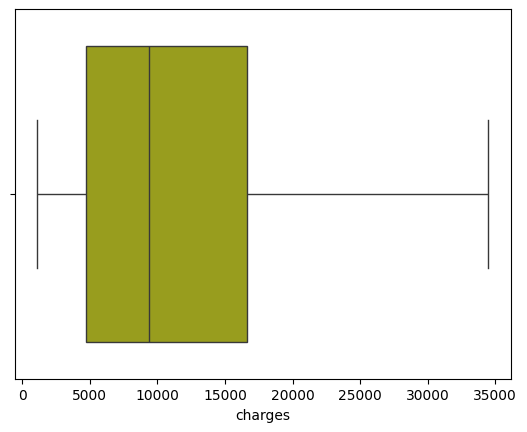

In [35]:
dfInsureUpperBound = changeOutliersInCol(insurance_df, 'charges')

In [36]:
# Compara las trazas de acuerdo con el indice para verificar que si se haya cambiado los valores del UpperBound
display(chargesOutliers.iloc[1].to_frame())
display(dfInsureUpperBound.iloc[19].to_frame())

,19
age,30
sex,male
bmi,35.3
children,0
smoker,yes
region,southwest
charges,36837.467


,19
age,30
sex,male
bmi,35.3
children,0
smoker,yes
region,southwest
charges,34489.350562


In [37]:
X2 = dfInsureUpperBound.drop('charges', axis = 1)
y2 = dfInsureUpperBound['charges']
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y2, train_size=0.8, random_state=1, stratify=dfInsureUpperBound['smoker'])

In [38]:
# Se crea el pipeline para la predicción, que incluye el de procesamiento creado anteriormente y la regresión lineal
lr_model2 = make_pipeline(preprocessing, LinearRegression())
lr_model2.fit(Xtrain2, ytrain2)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA07D908F0>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA08135220>)])),
                ('linearregression', LinearRegression())])

In [39]:
predictions2 = lr_model2.predict(Xtest2)

print('El RMSE es:', root_mean_squared_error(ytest2, predictions2))
print('El R2 es:', r2_score(ytest2, predictions2))

El RMSE es: 4812.061728319821
El R2 es: 0.7637776364359081


Observamos que se obtuvo una mejora en el modelo con las métricas consideradas.

In [40]:
yPredictions2 = pd.DataFrame(predictions2, columns=['chargesPredictions'])
dfCompare2 = pd.concat([yTestValues,yPredictions2], axis=1)
dfCompare2['diferencia'] = dfCompare2['charges'] - dfCompare2['chargesPredictions']
display(dfCompare2)

,charges,chargesPredictions,diferencia
0,13129.60345,11675.380212,1454.223238
1,17496.30600,24815.343956,-7319.037956
2,10422.91665,10196.808080,226.108570
3,16085.12750,16422.509573,-337.382073
4,3757.84480,5053.327985,-1295.483185
...,...,...,...
263,6414.17800,7307.068285,-892.890285
264,10043.24900,11652.513710,-1609.264710
265,3044.21330,3905.077747,-860.864447
266,11554.22360,11433.892264,120.331336


9. Prepara otro transformador, denominado `preprocessing2`, para aplicar escalamiento estándar a los predictores numéricos y codificación ordinal a los categóricas. Aplícalo en un nuevo pipeline utilizando nuevamente regresión lineal. Guarda el modelo como `lr_model3`.

**Nota.** Los cambios se ejecutan de manera consecutiva, por ejemplo: el reemplazo de los outliers también se ejecuta previo al transformador `preprocessing2` y así sucesivamente.

In [41]:
# El transformador único podría ir directamente en el ColumnTransformer que aparece abajo
num_pipeline2 = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipeline2 = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())

preprocessing2 = ColumnTransformer([
    ('num', num_pipeline2, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline2, make_column_selector(dtype_include=object))])

# Se crea el pipeline para la predicción, que incluye el de procesamiento creado anteriormente y la regresión lineal
lr_model3 = make_pipeline(preprocessing2, LinearRegression())
lr_model3.fit(Xtrain2, ytrain2)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA088AD700>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AA088C8BF0>)])),
                ('linearregression', LinearRegression())])

In [42]:
predictions3 = lr_model3.predict(Xtest2)

print('El RMSE es:', root_mean_squared_error(ytest2, predictions3))
print('El R2 es:', r2_score(ytest2, predictions3))

El RMSE es: 4811.600670456455
El R2 es: 0.7638229005936741


In [43]:
yTestValues2 = (ytest2.to_frame()).reset_index(drop=True)
yPredictions3 = pd.DataFrame(predictions3, columns=['chargesPredictions'])
dfCompare3 = pd.concat([yTestValues2,yPredictions3], axis=1)
dfCompare3['diferencia'] = dfCompare3['charges'] - dfCompare3['chargesPredictions']
display(dfCompare3)

,charges,chargesPredictions,diferencia
0,13129.60345,11756.141637,1373.461813
1,17496.30600,24766.746229,-7270.440229
2,10422.91665,10275.003284,147.913366
3,16085.12750,16545.098868,-459.971368
4,3757.84480,5209.063443,-1451.218643
...,...,...,...
263,6414.17800,7286.468117,-872.290117
264,10043.24900,11702.564910,-1659.315910
265,3044.21330,3971.849065,-927.635765
266,11554.22360,11594.222587,-39.998987


10. Utiliza regresión polinomial para verificar si se produce un mejor ajuste. Intenta con varios grados, aunque debes dejar en el código sólo el de mejor rendimiento. Guarda el modelo como `lr_model4`.

Generamos una función para probar distintos grados y quedarnos con el mejor:

In [44]:
def evaluate_polynomial_regression(X_train, X_test, y_train, y_test, preprocessing, max_degree):
    """
    Evalúa modelos de regresión polinomial de diferentes grados, y retorna el mejor grado con el menor RMSE.
    Además, genera una gráfica de RMSE vs grados del polinomio.

    Args:
    - X_train, X_test: Conjuntos de entrenamiento y prueba de los predictores.
    - y_train, y_test: Conjuntos de entrenamiento y prueba de la variable de salida.
    - preprocessing: Pipeline de preprocesamiento de datos.
    - max_degree: Grado máximo de los polinomios a evaluar.

    Returns:
    - best_degree: El grado con el menor RMSE.
    - best_rmse: El RMSE correspondiente al mejor grado.
    - best_r2: El R2 correspondiente al mejor grado.
    - results: Un diccionario con los RMSE y R2 para cada grado.
    """
    results = {}
    best_rmse = float('inf')
    best_degree = 0

    degrees = []
    rmses = []

    for degree in range(1, max_degree + 1):
        # Creamos el pipeline para el modelo polinomial de cada grado
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
        lr_model4 = Pipeline([
            ('preprocessing', preprocessing),  # Paso de preprocesamiento
            ('poly_features', polynomial_features),  # Generamos las características polinomiales del grado actual
            ('model', LinearRegression())  # Modelo de regresión lineal
        ])

        # Entrenamos el modelo con el conjunto de entrenamiento
        lr_model4.fit(X_train, y_train)

        # Realizamos las predicciones en el conjunto de prueba
        y_pred = lr_model4.predict(X_test)

        # Calculamos el RMSE y R^2 para el modelo actual
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Guardamos los resultados para el grado actual
        results[degree] = {'RMSE': rmse, 'R2': r2}

        # Almacenamos los grados y RMSE para la gráfica
        degrees.append(degree)
        rmses.append(rmse)

        # Actualizamos el mejor modelo si el RMSE es menor
        if rmse < best_rmse:
            best_rmse = rmse
            best_degree = degree
            best_r2 = r2

    # Generamos la gráfica de RMSE vs grados del polinomio
    plt.figure(figsize=(15, 8))
    plt.plot(degrees, rmses, marker='o', color='b', linestyle='-')
    plt.title('RMSE vs Grado del Polinomio')
    plt.xlabel('Grado del Polinomio')
    plt.ylabel('RMSE')
    plt.xticks(degrees)
    plt.grid(True)

    # Se formatea el eje Y para mostrar miles con coma
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    # Agregamos valores de RMSE en cada punto
    for degree, rmse in zip(degrees, rmses):
        plt.text(degree, rmse, f'{rmse:,.2f}', ha='center', va='bottom', fontsize=9)


    return best_degree, best_rmse, best_r2, results

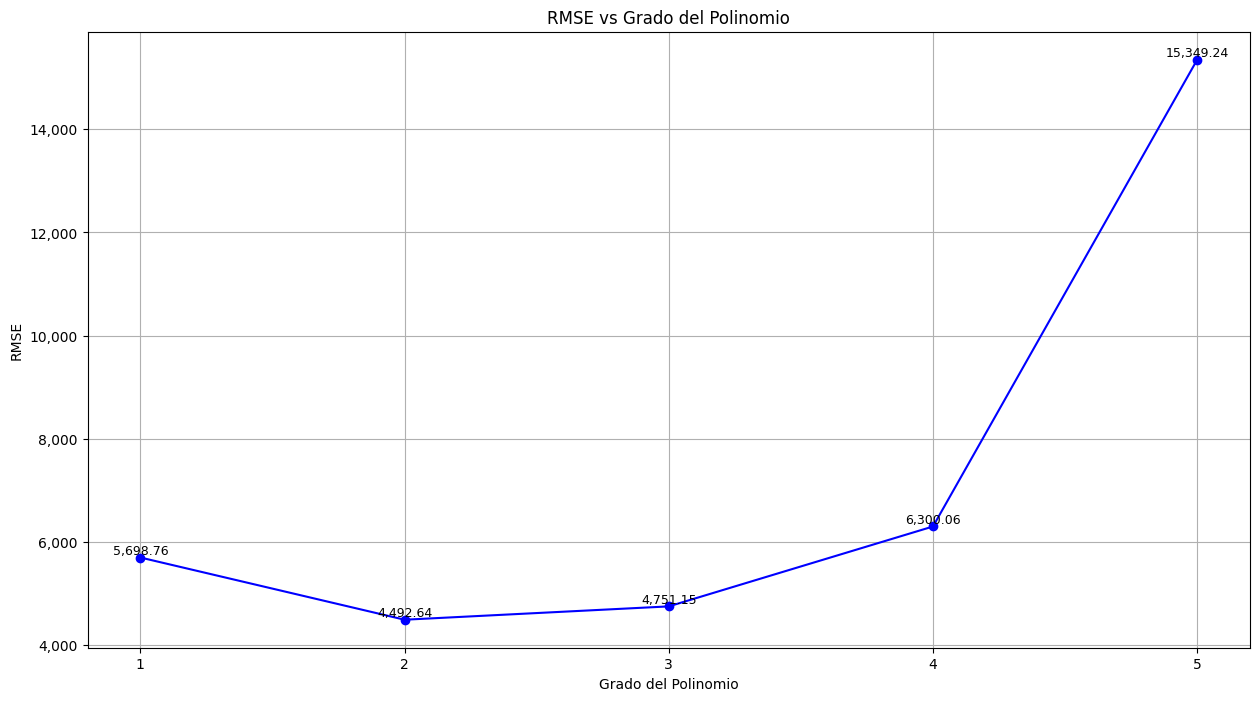

In [45]:
# Evaluamos modelos de regresión polinomial desde grado 1 hasta grado 5
best_degree, best_rmse, best_r2, results = evaluate_polynomial_regression(Xtrain, Xtest, ytrain, ytest, preprocessing=preprocessing, max_degree=5)

In [46]:
print('Resultados:')
dfResults = pd.DataFrame(results).T.reset_index().rename(columns={"index": "grado"})
display(dfResults)
minRMSEResult1Index = dfResults['RMSE'].idxmin()
display('Mejor grado y RMSE para el preprocessing (1), Xtrain, ytrain, Xtest (Datos originales):')
display((dfResults.iloc[[minRMSEResult1Index]]))

Resultados:


,grado,RMSE,R2
0,1,5698.759785,0.753855
1,2,4492.644885,0.847020
2,3,4751.153063,0.828908
3,4,6300.063886,0.699170
4,5,15349.235747,-0.785683


'Mejor grado y RMSE para el preprocessing (1), Xtrain, ytrain, Xtest (Datos originales):'

,grado,RMSE,R2
1,2,4492.644885,0.84702


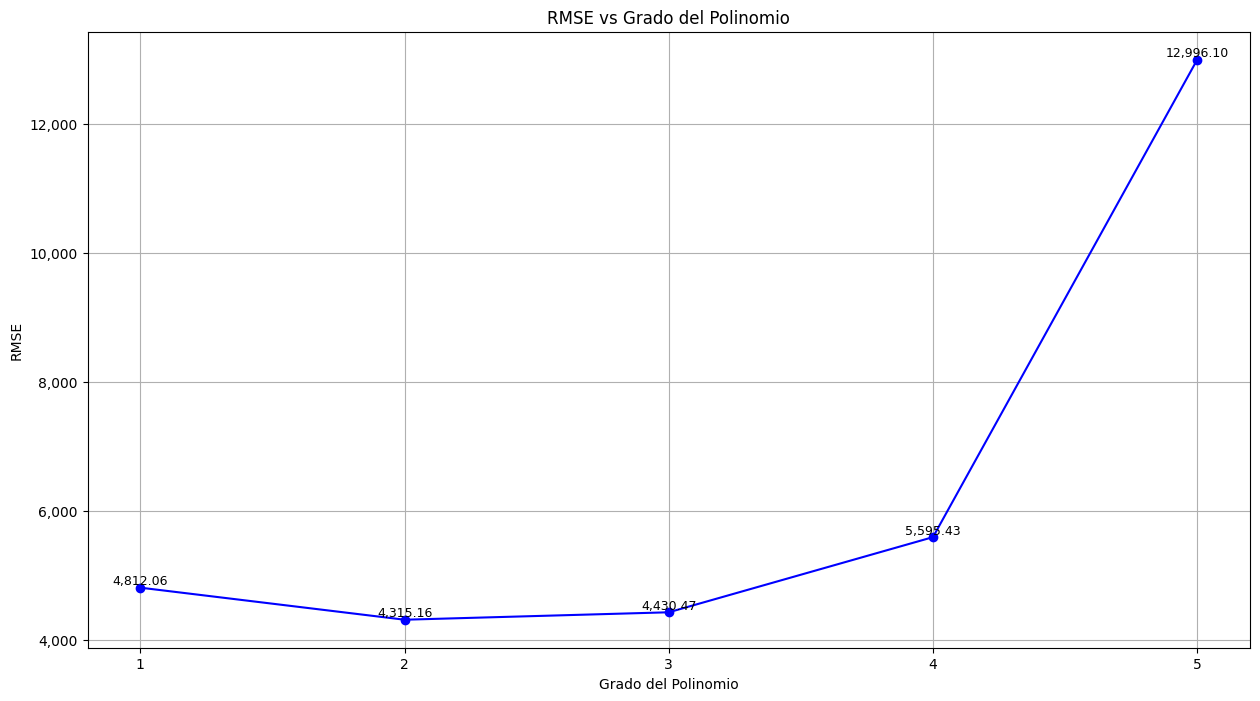

In [47]:
# Evaluamos modelos de regresión polinomial desde grado 1 hasta grado 5
best_degree2, best_rmse2, best_r22, results2 = evaluate_polynomial_regression(Xtrain2, Xtest2, ytrain2, ytest2, preprocessing=preprocessing, max_degree=5)

In [48]:
print('Resultados:')
dfResults2 = pd.DataFrame(results2).T.reset_index().rename(columns={"index": "grado"})
display(dfResults2)
minRMSEResult2Index = dfResults2['RMSE'].idxmin()
display('Mejor grado y RMSE para el preprocessing (1), Xtrain2, ytrain2, Xtest2 (Datos imputados):')
display((dfResults2.iloc[[minRMSEResult2Index]]))

Resultados:


,grado,RMSE,R2
0,1,4812.061728,0.763778
1,2,4315.160575,0.810044
2,3,4430.472166,0.799756
3,4,5595.432747,0.680607
4,5,12996.101709,-0.722998


'Mejor grado y RMSE para el preprocessing (1), Xtrain2, ytrain2, Xtest2 (Datos imputados):'

,grado,RMSE,R2
1,2,4315.160575,0.810044


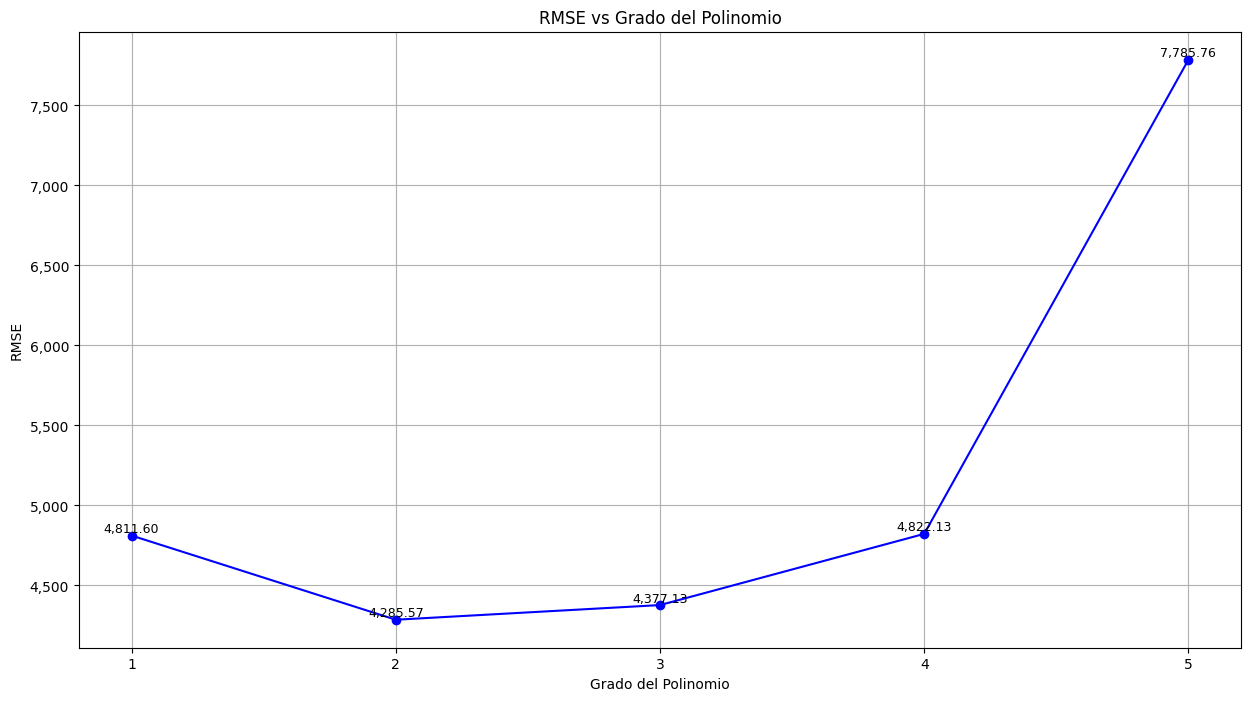

In [49]:
# Evaluamos modelos de regresión polinomial desde grado 1 hasta grado 5
best_degree3, best_rmse3, best_r23, results3 = evaluate_polynomial_regression(Xtrain2, Xtest2, ytrain2, ytest2, preprocessing=preprocessing2, max_degree=5)

In [50]:
print('Resultados:')
dfResults3 = pd.DataFrame(results3).T.reset_index().rename(columns={"index": "grado"})
display(dfResults3)
minRMSEResult3Index = dfResults3['RMSE'].idxmin()
display('Mejor grado y RMSE para el preprocessing (2), Xtrain2, ytrain2, Xtest2 (Datos imputados):')
display((dfResults3.iloc[[minRMSEResult3Index]]))

Resultados:


,grado,RMSE,R2
0,1,4811.600670,0.763823
1,2,4285.570311,0.812640
2,3,4377.131392,0.804549
3,4,4822.131659,0.762788
4,5,7785.762801,0.381612


'Mejor grado y RMSE para el preprocessing (2), Xtrain2, ytrain2, Xtest2 (Datos imputados):'

,grado,RMSE,R2
1,2,4285.570311,0.81264
